# Probabilistic Programming - Final Project
## Recommendation System using Hierarchical Poisson Factorization 
### Stan Eduard-George (407 AI)

We start by importing the libraries that we'll work with.

In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

The data used for this project is Fashion Products dataset (Can be accessed at https://www.kaggle.com/datasets/bhanupratapbiswas/fashion-products).

Then, we read the dataset and store it in a pd.DataFrame. We perform a quick check of the most important characteristics of our data (number of rows and columns, data types, missing values, memory usage).

In [2]:
data = pd.read_csv("fashion_products.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   User ID       1000 non-null   int64  
 1   Product ID    1000 non-null   int64  
 2   Product Name  1000 non-null   object 
 3   Brand         1000 non-null   object 
 4   Category      1000 non-null   object 
 5   Price         1000 non-null   int64  
 6   Rating        1000 non-null   float64
 7   Color         1000 non-null   object 
 8   Size          1000 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 70.4+ KB


We display the first 5 rows, so that we can see how the values really look. We notice three categorical columns - **Brand**, **Product Name**, **Category**. These columns can be used to detect the users that rated more specific or more general articles. 

In [3]:
data.head(5)

,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M


We set to 75 the number of unique users and articles that we'll use for our model. We combine the three columns observed earlier. This means that we want to extract the most relevant information possible about the products that we're going to recommend.

Next, we extract all articles, and we can display their names and number of ratings if we uncomment the print function.

In [4]:
dimension = 75
data["Article"] = data["Brand"] + ' ' + data["Product Name"] + ' ' + data["Category"]
unique_articles, counts_articles = np.unique(data["Article"], return_counts=True)

best_unique_articles = unique_articles[np.argsort(counts_articles)[-dimension:][::-1]]
best_counts_articles = counts_articles[np.argsort(counts_articles)[-dimension:][::-1]]

# print(f"Number of unique articles: {len(unique_articles)}\n\nTop {dimension} most frequently rated articles:\n\
#       {best_unique_articles} \n\nCounts of the mentioned articles:\n\
#       {best_counts_articles}")

We do the same thing as earlier with the Users' IDs. The total number of unique users is 100, so we need to truncate this number to 75 in order to have a square matrix of Users vs Articles.

In [5]:
unique_user, counts_user = np.unique(data["User ID"], return_counts=True)
best_unique_user = unique_user[np.argsort(counts_user)[-dimension:][::-1]]
best_counts_user = counts_user[np.argsort(counts_user)[-dimension:][::-1]]
# print(f"Number of unique users: {len(unique_user)}\n\nTop {dimension} most active users by ID:\n\
#       {best_unique_user} \n\nThe number of their ratings:\n\
#       {best_counts_user}")

At this step, we create the final dataset.
We select only the instances that contain the most rated articles and the most active users. This way, the new dataset has 851 rows.

In [6]:
selected_rows = data[(data['Article'].isin(best_unique_articles)) & (data['User ID'].isin(best_unique_user))]
best_samples_data = selected_rows[['User ID', 'Article', 'Rating']]
f"Number of instances in best_samples_data: {len(best_samples_data)}"

'Number of instances in best_samples_data: 851'

We factorize the values of columns **Article** and **User ID** to make them easier to interpret.

In [7]:
best_samples_data.loc[:,'Article'], _ = pd.factorize(best_samples_data['Article'])
best_samples_data.loc[:,'User ID'], _ = pd.factorize(best_samples_data['User ID'])
best_samples_data.head(5)

,User ID,Article,Rating
0,0,0,1.043159
1,1,1,4.026416
2,2,2,3.337938
4,3,3,4.302773
5,4,0,1.379566


Below, the interaction matrix of **Article** vs **User ID** is computed.

In [9]:
inter_matrix = np.array(pd.pivot_table(best_samples_data, values='Rating', index='User ID', columns='Article', fill_value=0))

The following hyperparameters were chosen based on the grid search perform in the second file.

In [10]:
# Create the PyMC3 model
with pm.Model() as model:
    # Define hyperparameters for the user gamma distributions
    a, a_pr, b, b_pr = 0.1, 0.1, 0.1, 0.1
    # initialize the user parameters for each user u:
    # - sample activity: ξ_u ~ Gamma(a', a'/b')
    # - sample preference for each component k: θ_uk ~ Gamma(a, ξ_u)
    sample_activity = pm.Gamma('sample_activity', alpha=a_pr, beta=a_pr/b_pr, initval=np.mean(inter_matrix, axis=1), shape=dimension)
    theta = pm.Gamma('theta', alpha=a, beta=sample_activity, initval=np.random.rand(dimension, dimension), shape=(dimension, dimension))

    # Define hyperparameters for the item gamma distributions
    c, c_pr, d, d_pr = 0.1, 0.1, 0.1, 0.1
    # A useless distribution that I forgot about before running the model. It was previously used to 
    # generate a prior value for alpha parameter of sample_popularity Gamma distribution.
    # It does not affect the final results in any sense, so it can be ignored from now on.
    prior_alpha_popularity = pm.Gamma("prior_alpha_popularity", alpha=c_pr, beta=d_pr, initval=12)

    # initialize the item parameters for each item i:
    # - sample popularity: η_i ~ Gamma(c', c'/d')
    # - sample attribute for each component k: β_ik ~ Gamma(c, η_i)
    sample_popularity = pm.Gamma('sample_popularity', alpha=c_pr, beta=c_pr/d_pr, initval=np.mean(inter_matrix, axis=0), shape=dimension)
    beta = pm.Gamma('beta', alpha=c, beta=sample_popularity, initval=np.random.rand(dimension, dimension), shape=(dimension, dimension))

    # sample rating for each user u and item i: y_ui ~ Gamma(Transpose(θ_uk) • β_ik)
    ratings = pm.Poisson('ratings', mu=pm.math.dot(theta.T, beta), observed=inter_matrix)

    # define the trace that we're going to use for drawing our predictions. 
    # `target_accept` parameter controls the acceptance probability of proposed steps in the NUTS algorithm.
    trace = pm.sample(1000, tune=500, cores=2, return_inferencedata=False, target_accept=0.9)

    # generate samples from the posterior predictive distribution based on the trace.
    posterior_predictive = pm.sample_posterior_predictive(trace)
    ratings_samples = posterior_predictive['ratings']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 5159 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


We check the Mean Absolute Error between the original interaction matrix and the predicted one. The predicted interaction matrix is the mean between all draws computed by our model. 

MAE has a value of ~0.43. This value is relatively high, related to our range of values (from 0 to 5). Although this value is not amazing, the studies performed on the grid search reveal that the predicted values are more inclined towards the mean (e.g. 0 goes to 0.3 and 4.8 goes to 3.7). However, with the right processing, this model can work very well, especially in the context of fashion articles recommendations, where it's rather appreciated to recommend outliers from time to time.

In [11]:
predicted_ratings = np.mean(ratings_samples, axis=0)
mae = np.mean(np.abs(predicted_ratings - inter_matrix))
print(mae)

0.4302505459760227


On the left we have the histograms of the distributions used by the model, and on the right there are the actual traces. As expected, we observe no divergences (the divergece points would be displayed as black vertical lines), and the distributions converge rapidly. On the right side, the graphs indicate (through the peaks) where parameter values are more likely to occurr. 

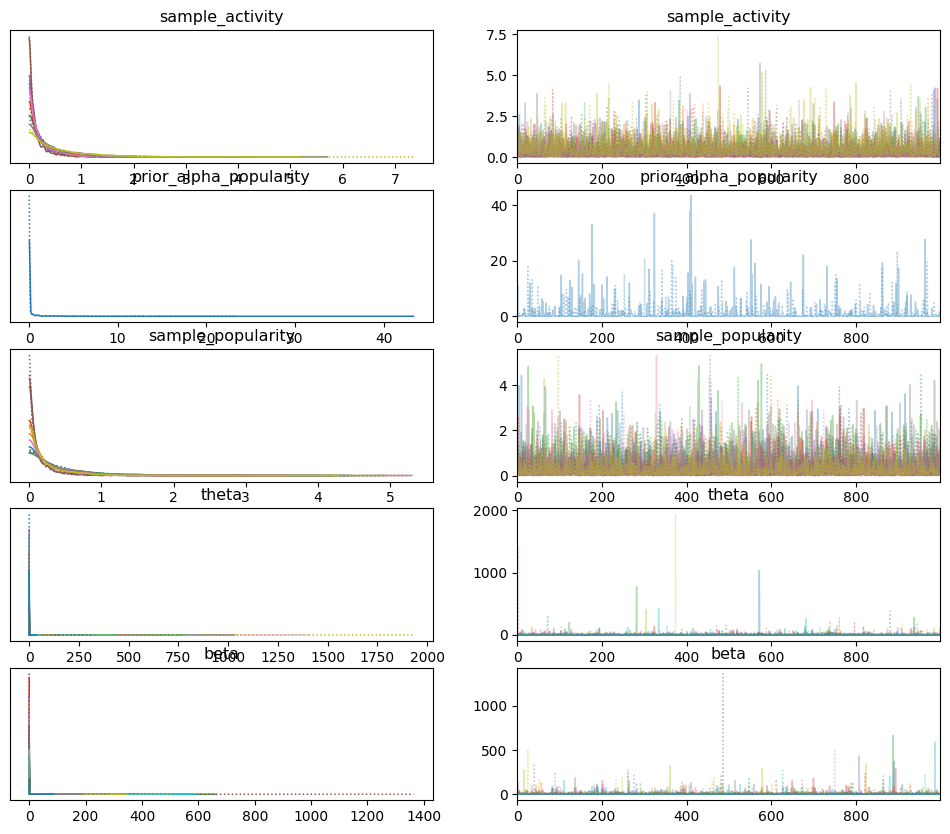

In [72]:
with pm.Model():
    az.plot_trace(trace)